# Calculate Archie Water Saturations after Fine-Tuning Electrical Properties to Pickett and Buckles Plots using Python's Panel Library

>**Beta software. Please consider this work in progress** 

While experimenting with interactive python tools for our next GitHub repository, we came upon a python library called panel. Panel appears to provide the type of interaction that we need for our petrophysical analysis. This simple example represents work in progress, but we have placed this python tool in this GitHub repository for others to try use and hopefully improve upon what we have so far.

In the animated example below, we are calculating Archie water saturations from a Costa Field well. The panel tool shown below calculates a new water saturation as you vary the electrical properties (a, m and n) or Rw. The tool provides instantaneous results that are seen from from the changes in the saturation lines in the Pickett plot as well as the changes in BVW seen in the depth plot.

Panel provides the type of interactivity that allows the user to fine-tune their analysis using both the Pickett and Buckles plots. The Pickett plot is fundamental to our calculation of water saturations from conventional logs, and this tool allows you to build a better understanding of your data to develop a better feel for the sensitivity of each parameter used in the Archie water saturation calculation (a, m, n and Rw). 

In this example well, the interval at the bottom of the depth plot appears to be wet. However, is this interval at 100% Sw or does it contain some residual oil? We do not have residual fluid saturations from core to allow us to make that determination, so we have made the assumption that this intervals is 100% water saturated for now. 

In this example we adjust the m and Rw to give us 100% water saturations from logs for this lower interval. You can then adjust the n to give you the expected BVW from the Buckles plot. We have added an Archie 'a' tortuosity parameter slider too for you to experiment with.
>---
>**From Craig Phillips GitHub repositories: (https://github.com/Philliec459)**
>---
>
>![Panel_log](./pickett_log_sats3.gif)
>
>---

**Load python libraries:**

In [1]:
import numpy as np
import pandas as pd
import datashader as ds
import panel as pn
pn.extension()

pn.extension(sizing_mode="stretch_width")

from numba import jit
from datashader import transfer_functions as tf
from colorcet import palette_n


import math
import openpyxl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import lasio

%matplotlib inline

## Load las file with Lasio:

In [2]:
las = lasio.read("./HW-10.las");elev_meas_ref = 453

In [3]:
las.keys()

['DEPT',
 'GR',
 'RHOB',
 'NPHI',
 'DT',
 'PHIE',
 'RT',
 'SW',
 'SO',
 'CORE_POR',
 'CORE_PERM']

In [4]:
for item in las.well:
    print(f"{item.descr} ({item.mnemonic}): {item.value}")

 (STRT): 8150.0
 (STOP): 8630.0
 (STEP): 0.5
 (NULL): -999.25
COMPANY (COMP): 
WELL (WELL): HW-10
FIELD (FLD): COSTA
LOCATION (LOC): 
SERVICE COMPANY (SRVC): 
ss} (DATE): 2018-02-06 14:55:39   : Log Export Date {yyyy-MM-dd HH:mm
PROVINCE (PROV): 
UNIQUE WELL ID (UWI): HW-10
API NUMBER (API): 


In [5]:
las.df()

,GR,RHOB,NPHI,DT,PHIE,RT,SW,SO,CORE_POR,CORE_PERM
DEPT,,,,,,,,,,
8440.0,31.66,2.73,0.07,NaN,0.0,17.62,NaN,NaN,NaN,NaN
8440.5,30.61,2.73,0.06,NaN,0.0,19.01,NaN,NaN,NaN,NaN
8441.0,29.37,2.72,0.06,NaN,0.0,20.33,NaN,NaN,NaN,NaN
8441.5,28.05,2.73,0.05,NaN,0.0,21.58,NaN,NaN,NaN,NaN
8442.0,27.10,2.73,0.05,NaN,0.0,22.79,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
8628.0,23.40,2.73,0.04,NaN,0.0,21.26,NaN,NaN,NaN,NaN
8628.5,27.49,2.74,0.04,NaN,0.0,20.30,NaN,NaN,NaN,NaN
8629.0,32.21,2.74,0.04,NaN,0.0,20.14,NaN,NaN,NaN,NaN


## Create DataFrame from las file:

In [6]:
df_log = las.df()
df_log.head()

,GR,RHOB,NPHI,DT,PHIE,RT,SW,SO,CORE_POR,CORE_PERM
DEPT,,,,,,,,,,
8440.0,31.66,2.73,0.07,NaN,0.0,17.62,NaN,NaN,NaN,NaN
8440.5,30.61,2.73,0.06,NaN,0.0,19.01,NaN,NaN,NaN,NaN
8441.0,29.37,2.72,0.06,NaN,0.0,20.33,NaN,NaN,NaN,NaN
8441.5,28.05,2.73,0.05,NaN,0.0,21.58,NaN,NaN,NaN,NaN
8442.0,27.10,2.73,0.05,NaN,0.0,22.79,NaN,NaN,NaN,NaN


In [7]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 381 entries, 8440.0 to 8630.0
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GR         381 non-null    float64
 1   RHOB       381 non-null    float64
 2   NPHI       381 non-null    float64
 3   DT         0 non-null      float64
 4   PHIE       381 non-null    float64
 5   RT         381 non-null    float64
 6   SW         160 non-null    float64
 7   SO         160 non-null    float64
 8   CORE_POR   311 non-null    float64
 9   CORE_PERM  311 non-null    float64
dtypes: float64(10)
memory usage: 32.7 KB


In [8]:
#df_log.dropna(inplace=True)

In [9]:
df_log.head()

,GR,RHOB,NPHI,DT,PHIE,RT,SW,SO,CORE_POR,CORE_PERM
DEPT,,,,,,,,,,
8440.0,31.66,2.73,0.07,NaN,0.0,17.62,NaN,NaN,NaN,NaN
8440.5,30.61,2.73,0.06,NaN,0.0,19.01,NaN,NaN,NaN,NaN
8441.0,29.37,2.72,0.06,NaN,0.0,20.33,NaN,NaN,NaN,NaN
8441.5,28.05,2.73,0.05,NaN,0.0,21.58,NaN,NaN,NaN,NaN
8442.0,27.10,2.73,0.05,NaN,0.0,22.79,NaN,NaN,NaN,NaN


## Calculate individual log curves for analysis:

the bvw curve being calclated below is just a place saver in order to have the curve bvw.

In [10]:
a = 1.0          # Archie 'a'
m = 1.9          # Electrical property m initial start
n = 1.8          # Electrical property n initial start
rw = 0.012       # Formation brine resistivity

gd = 2.71  # Matrix Density 
fd = 1.1   # Fluid Densitr

# Calculate Density Porosity
rhob = np.array(df_log['RHOB'])
ild  = np.array(df_log['RT'])
y    = np.array(las['DEPT'])
bvw  = np.array(df_log['RHOB'])  # Dummy place holder curve for bvw
swt  = np.array(df_log['RHOB'])   # Dummy place holder curve for Swt


porarray = []

for k in range(0,len(df_log),1):
    porarray.append((gd-rhob[k])/(gd-fd))
    if porarray[k]<=0:
        porarray[k]=0.001
    else:
        porarray[k]=porarray[k]

porarray=np.array(porarray)

## Define Primary Plot file:

### We wanted to plot more than one track for the depth plot, so we will use matplotlib subplots

#### Subplot cooridnate System
      0,0  0,1
      1,0  1,1
      2,0  2,1

#### or,  as a mosaic which is a bit more intuitive
      left right
       middle
       bottom


In [11]:
def Plot_sw(a, m, n, rw):

    
    fig, axs = plt.subplot_mosaic([['left', 'right'],['middle','middle'],['bottom', 'bottom']])
                              #constrained_layout=True)

    #fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7, 7))
    fig.suptitle('Saturations from Logs',color='blue' , fontsize=18)
    fig.subplots_adjust(top=0.95,wspace=0.1, hspace =.15)
    fig.set_figheight(15)
    fig.set_figwidth(6)
    
    # Depth Plot 
    axs['left'].plot(porarray, y,'-r', lw=1)#, label= 'PHIT')
    axs['left'].plot(bvw, y,'-k', lw=1)#, label= 'BVW')
    axs['left'].set_xlabel("Bulk Volume Calculations",color='blue')
    axs['left'].set_ylabel("Depth",color='blue')
    axs['left'].set_xlim(0.5, 0.0)
    axs['left'].set_ylim(max(y), min(y))
    axs['left'].fill_betweenx(y,porarray,bvw, color='green', label= 'BVO')
    axs['left'].fill_betweenx(y,bvw,0, color='cyan', label= 'BVW')
    axs['left'].legend()
    axs['left'].grid()

    # Depth Plot 
    #plt.axhline(y=0.5, color='r', linestyle='-')
    axs['right'].axvline(x=m,  color='r', linestyle='-', label= 'm')
    axs['right'].axvline(x=n,  color='b', linestyle='-.', label= 'n')
    axs['right'].set_xlabel("Electrical Properties",color='blue')
    axs['right'].set_ylabel("Depth",color='blue')
    axs['right'].set_xlim(1, 3)
    axs['right'].set_ylim(max(y), min(y))
    #axs['right'].fill_betweenx(y,porarray,bvw, color='green', label= 'BVO')
    #axs['right'].fill_betweenx(y,bvw,0, color='cyan', label= 'BVW')
    axs['right'].legend()
    axs['right'].grid()
    #axs[0, 1].remove()  # don't display empty ax
    
    #axs['left'].sharey(axs['right'])
    #axs['right'].sharey(axs['left'])
    
    # Pickett Plot
    axs['middle'].loglog(ild,porarray, 'ro')
    axs['middle'].set_xlim(0.01,1000)
    axs['middle'].set_ylim(0.01,1)
    axs['middle'].set_ylabel('PHIT [v/v]', color = 'blue')
    axs['middle'].set_xlabel('ILD [ohmm]', color = 'blue')
    axs['middle'].grid()
    axs['middle'].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    axs['middle'].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))   
    
    #calculate the saturation lines
    sw_plot=(1.0,0.8,0.6,0.4,0.2)
    phit_plot=(0.01,1)
    rt_plot=np.zeros((len(sw_plot),len(phit_plot)))

    for i in range (0,len(sw_plot)):
        for j in range (0,len(phit_plot)):
            rt_result=((rw)/(sw_plot[i]**n)*(a/(phit_plot[j]**m)))
            rt_plot[i,j]=rt_result      
    for i in range(0,len(sw_plot)):
        axs['middle'].plot(rt_plot[i],phit_plot, linewidth=2, label='SW '+str(int(sw_plot[i]*100))+'%')
        axs['middle'].legend (loc='best')
    axs['middle'].grid(True, which='both',ls='-' ,color='gray')

    
    
    
    
    # Buckles Plot
    #ax3.plot(swt, porarray, 'bo')
    #ax3.scatter(swt, porarray, bvw,c=bvw,  cmap="rainbow")
    axs['bottom'].scatter(swt, porarray,    marker='d',c=bvw,  cmap="gist_rainbow")
    axs['bottom'].set_xlim(0.0,1.0) 
    axs['bottom'].set_ylim(0.0,0.35)
    axs['bottom'].set_ylabel('PHIT [v/v]', color = 'blue')
    axs['bottom'].set_xlabel('Swt [v/v]' , color = 'blue')
    axs['bottom'].grid()
    
    return fig



## Explore Panel's interactive widgets:

We use interactive Sliders to vary a, m, n and Rw to calculate an Archie water saturation. The interactive nature of these Panel widgets allows the user to see their instantaneous calculations of BVW and the lines on the Pickett Plot as the parameters are varied. 

---
>**There are an extra set of plots that at the bottom of this cell that are not interactive. We are trying to remove these extra plots, but in this version this is a bug to be fixed** 

In [12]:
def calc_bvw(a, m, n, rw):
    for k in range(0,len(df_log) ,1):  

        ILD     = ild[k]
        PHIT    = porarray[k]

        # =================================================================================
        #       Saturation Calculations
        # =================================================================================
        BVW = PHIT*((a/PHIT**m) * (rw/ILD) )**(1/n)

        if BVW > PHIT:
            BVW=PHIT
        else:
            BVW=BVW

        if BVW < 0:
            BVW=0
        else:
            BVW=BVW
                    
        Swt = BVW/PHIT       
        if Swt < 0:
            Swt=0
        else:
            Swt=Swt
       
        BVO = (PHIT*(1-Swt))
        #bvo[k]=BVO
        swt[k]=Swt  
        bvw[k]=BVW

    return m,n,rw,a,bvw


def bvw_plot(a, m , n , rw ):
    bvw  = calc_bvw(a,m, n,rw)    
    swt  = calc_bvw(a,m,n,rw)
    return Plot_sw(a,m,n,rw)


## This is the Panel layout with ineractive widgets:

Row(sizing_mode='stretch_width')
    [0] Column(sizing_mode='fixed', width=400)
        [0] PNG(str, sizing_mode='stretch_width')
        [1] Markdown(str, sizing_mode='stretch_width')
        [2] Column(sizing_mode='stretch_width')
            [0] FloatSlider(end=1.5, format=PrintfTickFormatter(id='10..., name='Archie a = ', sizing_mode='stretch_width', start=0.5, step=0.01, value=1)
            [1] FloatSlider(end=3.0, format=PrintfTickFormatter(id='10..., name="Cementation E..., sizing_mode='stretch_width', start=1.0, step=0.05, value=1.8)
            [2] FloatSlider(end=3.0, format=PrintfTickFormatter(id='10..., name="Saturation Exponent '..., sizing_mode='stretch_width', start=1.0, step=0.05, value=1.9)
            [3] FloatSlider(end=0.05, format=PrintfTickFormatter(id='10..., name='Rw = ', sizing_mode='stretch_width', start=0.01, step=0.001, value=0.012)
    [1] VSpacer(width=10)
    [2] Row(sizing_mode='stretch_width')
        [0] Matplotlib(Figure, name='interactive00106', sizing_mode='stretch_width')
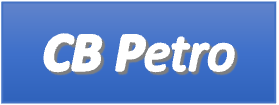
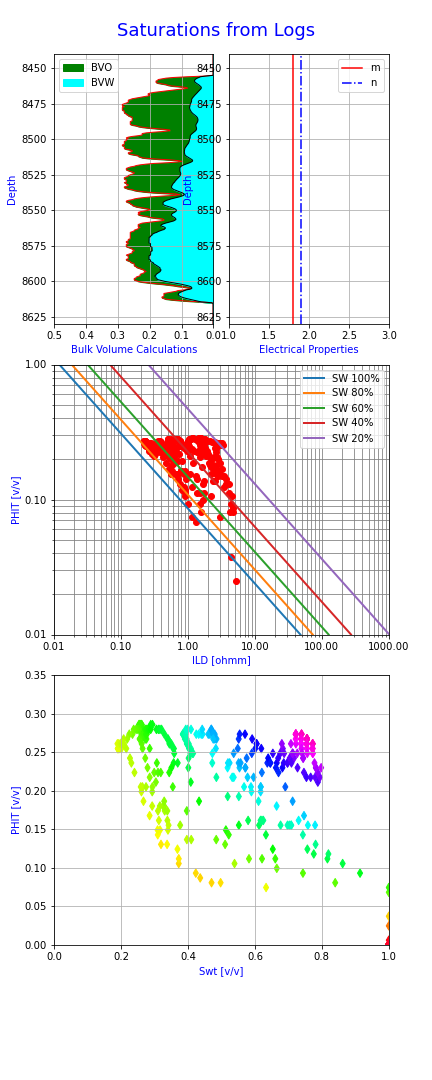

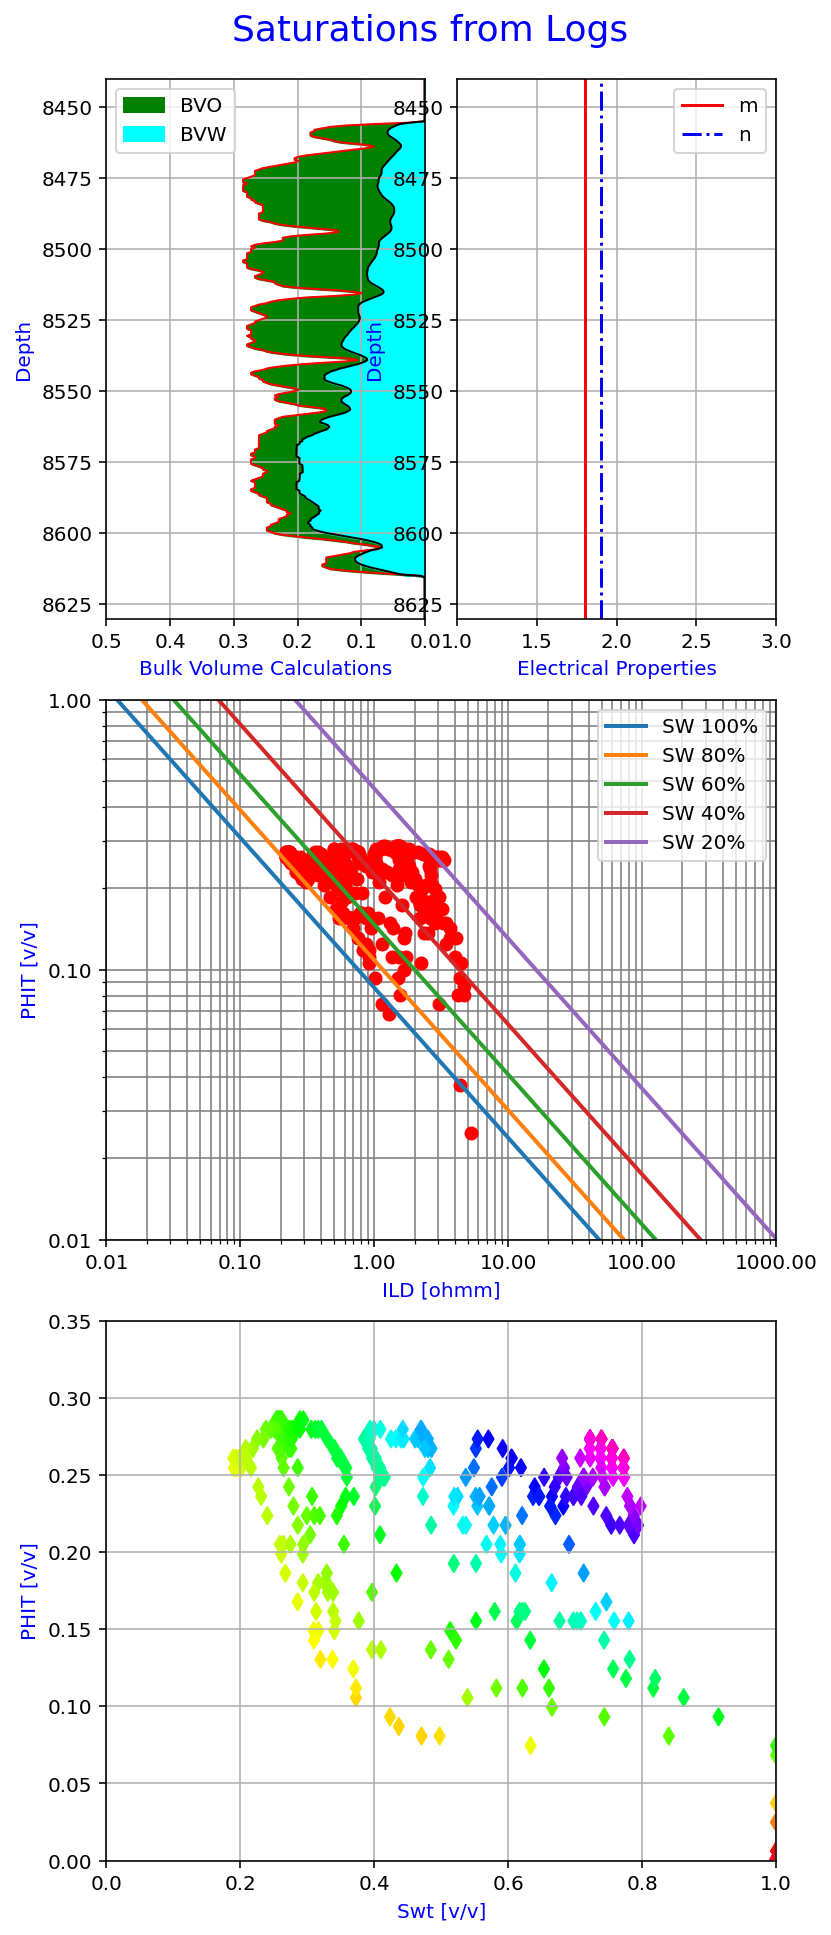

In [13]:
import matplotlib.ticker as ticker
from bokeh.models.formatters import PrintfTickFormatter

a_ticker  = pn.widgets.FloatSlider(name='Archie a = ', start=0.5, end=1.5, step=0.01, value=1, format=PrintfTickFormatter(format='%.3f'))
m_ticker  = pn.widgets.FloatSlider(name="Cementation Exponent 'm' = ", start=1.00, end=3.00, step=0.05, value=1.80, format=PrintfTickFormatter(format='%.2f'))
n_ticker  = pn.widgets.FloatSlider(name="Saturation Exponent 'n' = ", start=1.00, end=3.00, step=0.05, value=1.9, format=PrintfTickFormatter(format='%.2f'))
rw_ticker = pn.widgets.FloatSlider(name='Rw = ', start=0.01, end=0.05, step=0.001, value=0.012, format=PrintfTickFormatter(format='%.3f'))

pane = pn.interact(bvw_plot, a = a_ticker , m = m_ticker, n = n_ticker , rw = rw_ticker) #(float(0.0100), float(0.0500), float(0.0010)))


logo = "./CBPetro.png"
text = pn.pane.Markdown("""
# GitHub link: https://github.com/Philliec459
### This example demonstrates **how to use python's ``Panel interact`` function** to trigger updates to a, m, n and Rw for log calculated Archie water saturations.

#### You can **use the widgets slidebars below** to vary the electrical property parameters (a, m & n) as well as Rw for our Archie calculations.
""")


pn.Row(pn.Column( logo, text, pane[0], width=400, sizing_mode="fixed"), pn.layout.VSpacer(width=10),pane[1])


### Plot again using defined Plot_sw(m,n,rw):

In [14]:
#Plot_sw(a, m, n, rw)